In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import solve_ivp

import matplotlib_inline
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')

plt.rcParams['figure.figsize'] = (6.4*0.8, 4.8*0.8)

# Problem 1

Mole balances:

$\frac{dF_A}{dV}=-r_1v_0-r_2v_0$

$\frac{dF_B}{dV}=-2r_1v_0$

$\frac{dF_C}{dV}=2r_1v_0-r_2v_0$

$\frac{dF_D}{dV}=2r_2v_0$

Reactions:

$r_1=-k_1(T)C_AC_B^2$

$r_2=-k_2(T)C_AC_C$

Temperature:

Adbiabatic $Q_r=0$

$\frac{dT}{dV}=\frac{r_1\Delta H_1+r_2\Delta H_2}{F_AC_{P,A}+F_BC_{P,B}+F_CC_{P,C}+F_DC_{P,D}}$

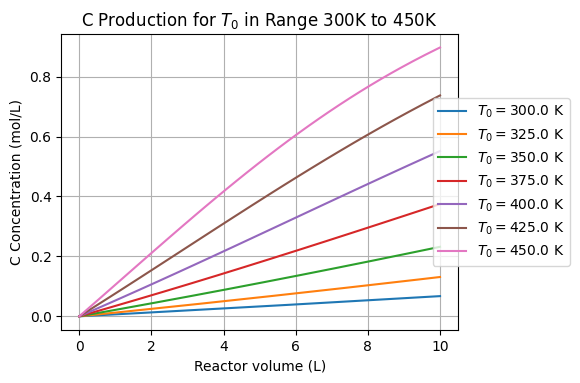

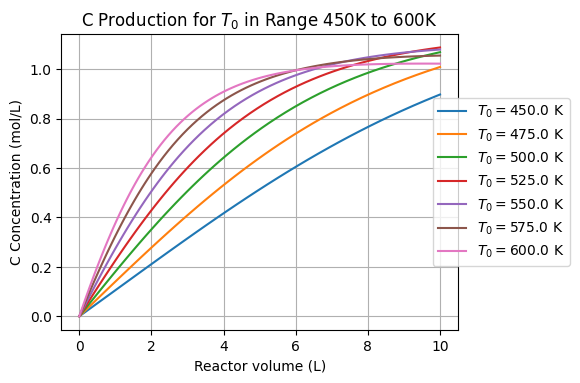

In [2]:
ode_kwargs = {
    'method': 'Radau',
    'atol': 1e-8,
    'rtol': 1e-8,
} 

def p1_ode(t, y):
    f = y*0

    C_A = y[0]
    C_B = y[1]
    C_C = y[2]
    C_D = y[3]
    T = y[4]

    v_0 = 10
    C_PA = 20
    C_PB = C_PA
    C_PC = 60
    C_PD = 80
    H_1 = -20000
    H_2 = 10000

    k_1 = 0.001 * np.exp(5000 * 4.184 / 8.314 * (1 / 300 - 1 / T))
    k_2 = 0.001 * np.exp(7500 * 4.184 / 8.314 * (1 / 300 - 1 / T))

    r_1 = -k_1 * C_A * (C_B)**2
    r_2 = -k_2 * C_A * C_C

    f[0] = (r_1 + r_2) / v_0
    f[1] = 2 * r_1 / v_0
    f[2] = (-2 * r_1 + r_2) / v_0
    f[3] = 2 * -r_2 / v_0
    f[4] = (r_1 * H_1 + r_2 * H_2) / (C_A * C_PA + C_B * C_PB + C_C * C_PC + C_D * C_PD) / 10

    return f

T_range = np.linspace(300, 600, 13)

p1_sols = []

for i, val in enumerate(T_range):
    ode_args = (
        p1_ode,
        [0, 10],
        [2, 4, 0, 0, val],
    )
    p1_sols.append(solve_ivp(*ode_args, **ode_kwargs))

for i in range(0, 7):
    plt.plot(p1_sols[i].t, p1_sols[i].y[2], label=rf"$T_0=${T_range[i]} K")

plt.xlabel("Reactor volume (L)")
plt.ylabel("C Concentration (mol/L)")
plt.title(r"C Production for $T_0$ in Range 300K to 450K")
plt.legend(loc="right", bbox_to_anchor=(1.3, 0.5))
plt.grid(which='both', axis='both')
plt.show()

for i in range(6, len(p1_sols)):
    plt.plot(p1_sols[i].t, p1_sols[i].y[2], label=rf"$T_0=${T_range[i]} K")

plt.xlabel("Reactor volume (L)")
plt.ylabel("C Concentration (mol/L)")
plt.title(r"C Production for $T_0$ in Range 450K to 600K")
plt.legend(loc="right", bbox_to_anchor=(1.3, 0.5))
plt.grid(which='both', axis='both')
plt.show()

Text(0.5, 1.0, 'C Production v Reactor Inlet Temperature')

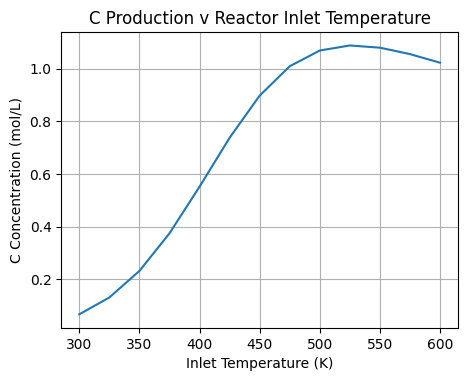

In [3]:
T_0_vals = []
C_C_vals = []

for sol in p1_sols:
    C_C_vals.append(sol.y[2][-1])
    T_0_vals.append(sol.y[4][0])
plt.grid(which='both', axis='both')
plt.plot(T_0_vals, C_C_vals)
plt.xlabel("Inlet Temperature (K)")
plt.ylabel("C Concentration (mol/L)")
plt.title("C Production v Reactor Inlet Temperature")

The concentration of C reaches a maximum of 1.1 mol/L at 525K. 525K is the optimal inlet temperature to maximize the production of C.

# Problem 2

$\epsilon=\frac{1}{2}-1=-\frac{1}{2}$

Concentrations in terms of X

$C_A=C_{A0}\left(\frac{1-X}{1-\frac{X}{2}}\right)p\frac{T_0}{T}$

$C_C=C_{A0}\left(\frac{X}{1-\frac{X}{2}}\right)p\frac{T_0}{T}$

Rate law

$r_A=-\left(k(T)C_A^2-\frac{k(T)}{K(T)}C_C\right)$

$k(T)=0.1\exp\left[\frac{8000}{8.314}\left(\frac{1}{450}-\frac{1}{T}\right)\right]$

$K(T)=10000\exp\left[\frac{-20000}{8.314}\left(\frac{1}{450}-\frac{1}{T}\right)\right]$

Design equation:

$\frac{dX}{dW}=\frac{r_A}{F_{A0}}$

Pressure drop

$\frac{dp}{dW}=-\frac{\alpha\left(1-\frac{X}{2}\right)}{2p}\frac{T}{T_0}$

Energy balance

$\frac{dT}{dW}=\frac{r_A\Delta H_{\text{Rx}}-Ua\left(T-T_a\right)}{F_{A0}\left(\sum\Theta_jC_{p,j}+X\Delta C_P\right)}$

$\sum\Theta_jC_{p,j}=C_{P,A}=40$

$\Delta C_P=\frac{1}{2}\cdot20-40=-30$

$\Delta H_{\text{Rx}(T)}=-20000-30(T-298)$

$\frac{dT}{dW}=\frac{r_A\Delta H_{\text{Rx}}-Ua\left(T-T_a\right)}{F_{A0}\left(40-30X\right)}$

Adiabatic case

$\frac{dT}{dW}=\frac{r_A\Delta H_{\text{Rx}}}{F_{A0}\left(40-30X\right)}$

Changing $T_a$ case

Parallel flow:

$\frac{dT_a}{dW}=\frac{Ua\left(T-T_a\right)}{\dot m_{\text{c}}C_{P,c}}$

Countercurrent flow:

$\frac{dT_a}{dW}=-\frac{Ua\left(T-T_a\right)}{\dot m_{\text{c}}C_{P,c}}$

In [4]:
C_A = lambda X, p, T: 1.9 * (1 - X) / (1 - X / 2) * p * 450 / T
C_C = lambda X, p, T: 1.9 * (X) / (1 - X / 2) * p * 450 / T / 1
dpdW = lambda X, p, T: -0.005 * (1 - X / 2) / 2 / p * T / 450
k = lambda T: 0.1 * np.exp(8000 / 8.314 *( 1 / 450 - 1 / T))
K = lambda T: 10000 * np.exp(-20000 / 8.314 * ( 1 / 450 - 1 / T))
r_A = lambda C_A, C_C, T: -k(T) * C_A**2 + k(T) / K(T) * C_C
H = lambda T: -20000 - 30 * (T - 298)

In [5]:
def p_2_adiabatic_ode(t, y):
    f = y*0

    X = y[0]
    p = y[1]
    T = y[2]

    f[0] = -r_A(C_A(X, p, T), C_C(X, p, T), T) / 5
    f[1] = dpdW(X, p, T)
    f[2] = (H(T) * r_A(C_A(X, p, T), C_C(X, p, T), T)) / (40 - 30 * X) / 5

    return f

def p_2_const_T_a_ode(t, y):
    f = y*0

    X = y[0]
    p = y[1]
    T = y[2]

    r = r_A(C_A(X, p, T), C_C(X, p, T), T)

    T_a = 500

    UA = 0.001 * 3600

    f[0] = -r / 5
    f[1] = dpdW(X, p, T)
    f[2] = (H(T) * r - UA * (T - T_a)) / (40 - 30 * X) / 5

    return f

def p_2_parallel_ode(t, y):
    f = y*0

    X = y[0]
    p = y[1]
    T = y[2]
    T_a = y[3]

    r = r_A(C_A(X, p, T), C_C(X, p, T), T)

    UA = 0.001 * 3600

    f[0] = -r / 5
    f[1] = dpdW(X, p, T)
    f[2] = (H(T) * r - UA * (T - T_a)) / (40 - 30 * X) / 5
    f[3] = UA * (T - T_a) / 0.05 / 4200

    return f

def p_2_counter_ode(t, y):
    f = y*0

    X = y[0]
    p = y[1]
    T = y[2]
    T_a = y[3]

    r = r_A(C_A(X, p, T), C_C(X, p, T), T)

    UA = 0.001 * 3600

    f[0] = -r / 5
    f[1] = dpdW(X, p, T)
    f[2] = (H(T) * r - UA * (T - T_a)) / (40 - 30 * X) / 5
    f[3] = -UA * (T - T_a) / 0.05 / 4200

    return f

In [6]:
p2_options = {
    'Adiabatic': {
        'args': (p_2_adiabatic_ode, [0, 90], [0, 1, 450]),
        'kwargs': {
            'method': 'Radau',
            'atol': 1e-8,
            'rtol': 1e-8,
        }
    }, 
    'Constant $T_a$': {
        'args': (p_2_const_T_a_ode, [0, 90], [0, 1, 450]),
        'kwargs': {
            'method': 'Radau',
            'atol': 1e-8,
            'rtol': 1e-8,
        }
    },
    'Parallel Flow': {
        'args': (p_2_parallel_ode, [0, 90], [0, 1, 450, 500]),
        'kwargs': {
            'method': 'Radau',
            'atol': 1e-8,
            'rtol': 1e-8,
        }
    },
    'Countercurrent Flow': {
        'args': (p_2_counter_ode, [0, 90], [0, 1, 450, 904.6523]),
        'kwargs': {
            'method': 'Radau',
            'atol': 1e-8,
            'rtol': 1e-8,
        }
    },
}

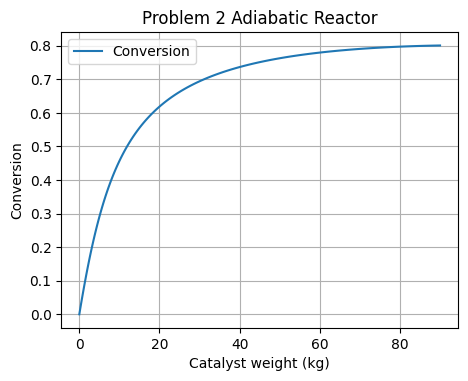

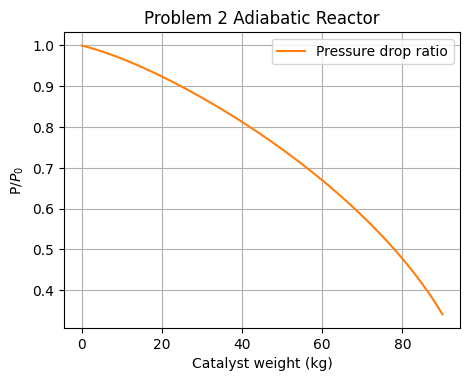

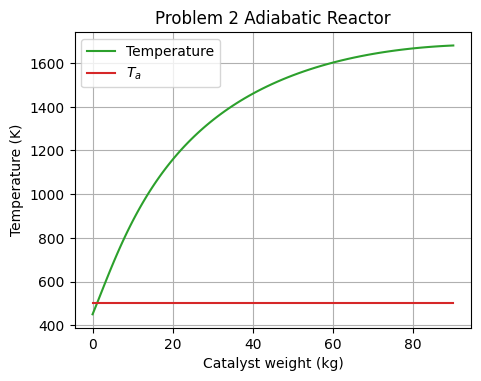

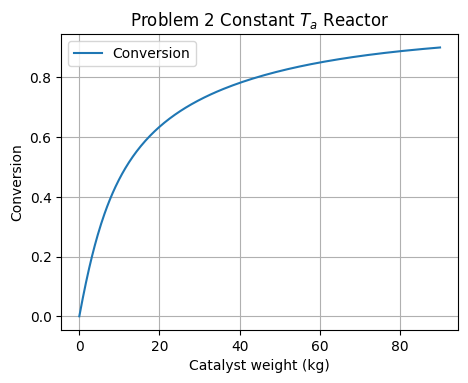

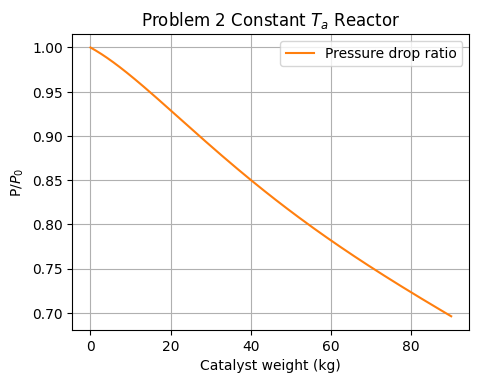

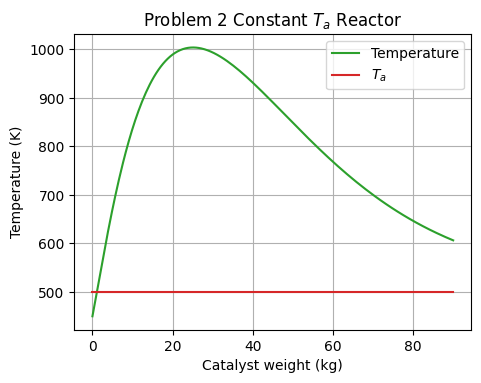

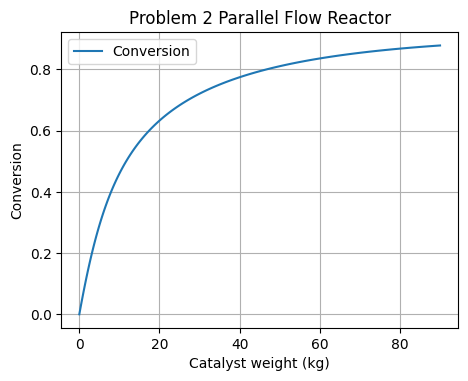

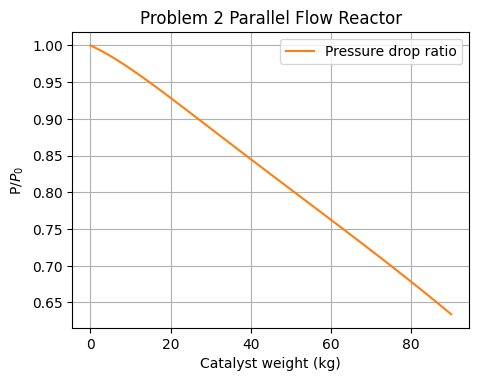

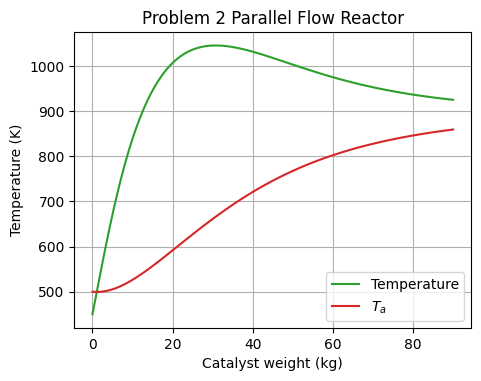

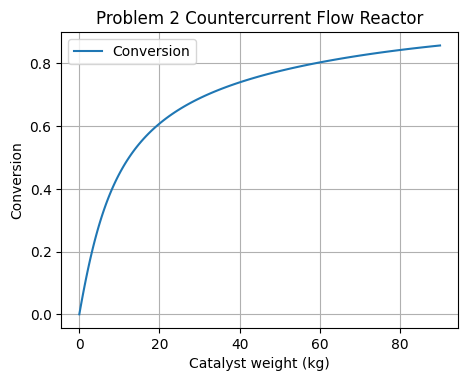

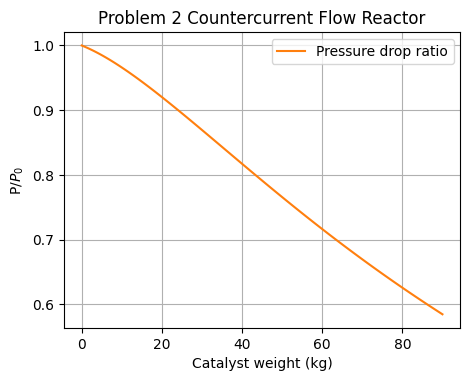

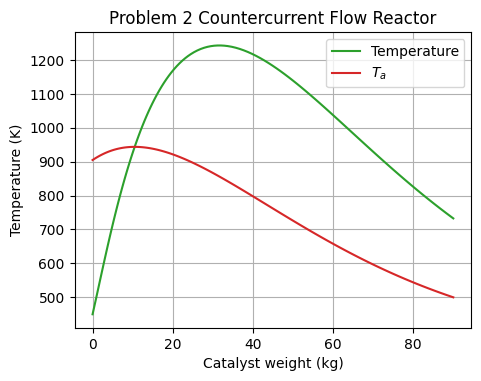

In [7]:
for key in p2_options:
    p2_sol = solve_ivp(*p2_options[key]['args'], **p2_options[key]['kwargs'])

    plt.plot(p2_sol.t, p2_sol.y[0], 'tab:blue', label="Conversion")
    plt.ylabel("Conversion")
    plt.title(rf"Problem 2 {key} Reactor")
    plt.xlabel("Catalyst weight (kg)")
    plt.grid(which='both', axis='both')
    plt.legend()
    plt.show()

    plt.plot(p2_sol.t, p2_sol.y[1], 'tab:orange', label="Pressure drop ratio")
    plt.ylabel(r"P/$P_0$")
    plt.title(rf"Problem 2 {key} Reactor")
    plt.xlabel("Catalyst weight (kg)")
    plt.grid(which='both', axis='both')
    plt.legend()
    plt.show()

    plt.plot(p2_sol.t, p2_sol.y[2], 'tab:green', label="Temperature")
    plt.ylabel("Temperature (K)")
    try:
        plt.plot(p2_sol.t, p2_sol.y[3], 'tab:red', label=r"$T_a$")
    except:
        plt.plot(p2_sol.t, np.ones(p2_sol.t.shape[0])*500, 'tab:red', label=r"$T_a$")
    plt.title(rf"Problem 2 {key} Reactor")
    plt.xlabel("Catalyst weight (kg)")
    plt.title(rf"Problem 2 {key} Reactor")
    plt.grid(which='both', axis='both')
    plt.legend()
    plt.show()

# Problem 3

Rate law:

$r_A=k\frac{N_A}{V}$

Design equation:

$\frac{dN_A}{dt}=-r_AV=-kN_A$

Analytical solution:

$\int\frac{dN_A}{N_A}=\int-kdt$

$\ln\frac{N_A}{N_{A0}}=-kt$

$N_A=N_{A0}e^{-kt}$

For $\frac{dT}{dt}=0$, energy balance must be $Q_g=Q_r$

$Q_g=r_AV\Delta H_{\text{rx}}^\circ=kN_{A0}e^{-kt}\Delta H_{\text{rx}}^\circ$

$Q_r=F_cC_{P,c}\left(T-T_0\right)$

$\frac{dT}{dt}=0$

$Q_g=-Q_r$

$F_c=-\frac{kN_{A0}e^{-kt}\Delta H_{\text{rx}}^\circ}{C_{P,c}\left(T-T_0\right)}$

At 2 h

$F_c=-\frac{1.2\cdot 10^{-4}\cdot 0.5 \cdot 50 \cdot e^{-1.2\cdot 10^{-4} \cdot 2 \cdot 3600} \cdot -25000}{0.5 \cdot \left(100-80\right)}$

$\boxed{F_c=3.16\text{ lb/s}}$